In [8]:
import os
os.environ['R_HOME'] = "C:/PROGRA~1/R/R-43~1.0"

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
from sawg.expression_dataset import ExpressionDataset, GeneBasisMethod, GenePanelSelection

In [2]:
directory = '//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/gene_panel_runs/'

In [3]:
ait19_tax = ad.read_h5ad('//allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/10x_seq/Human_BG_AIT_19/AI_taxonomy.h5ad',)

In [41]:
# load data
exp_data = ExpressionDataset(
    expression_data=ait19_tax,  # dataframe, one cell per row, index is sample names, columns are genes
    save_path = directory, # path to save to for later recall
    expression_type = 'logcpm',
    region = 'AIT19',
)

gene panel UID: 1687795499.278


In [4]:
exp_data = ExpressionDataset.load_from_timestamp(directory=directory, timestamp='1687795499.278')

In [5]:
starting_genes = pd.read_excel(directory + 'Human_NHP_BG_NSForest_BinaryMarkers_SpatialCurated.xlsx', sheet_name='Human')
sg_list = starting_genes['NSF Markers'].to_list()
sg_list = [g.strip(' ') for g in sg_list if type(g)==str]
len(sg_list)

59

In [6]:
hvgs = exp_data.expression_data.var[exp_data.expression_data.var['highly_variable_genes']==True]['gene'].to_list()
genes = list(set(hvgs + sg_list))
genes = list(set([g.strip(' ') for g in genes]))
print(len(genes))
hvg_exp_data = exp_data.select_genes(genes=genes)

2008


Start with geneBasis, starter gene list + 100 genes

In [9]:
# geneBasis gene selection
# first convert to SCE format

gene_basis = GeneBasisMethod(exp_data=hvg_exp_data)

gene_basis.save_to_csv()

pandas2ri activated
pandas2ri activated
//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/gene_panel_runs/1687795499.278\expression_data.csv already exists
//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/gene_panel_runs/1687795499.278\annotation_data.csv already exists


In [79]:
# select genes
size = len(sg_list) + 100
print(size)
job = gene_basis.select_gene_panel(size=size, args={'genes_base': sg_list}, run_on_hpc=True, hpc_args={'time': '24:00:00'})

159
building HPC job
<JobState RUNNING> 9774035


In [63]:
job.state()

<JobState RUNNING>

In [ ]:
gb_panel = gene_basis.load_gene_panel(args={'genes_base': sg_list})

Map with ScrattchMapping

In [5]:
from sawg import ScrattchMapping

In [6]:
panel_meta = gb_panel.args
gb_panel.eval_method(method = ScrattchMapping(
    sp_data = gb_panel.exp_data.expression_data[: , gb_panel.gene_panel],
    taxonomy_path = '//allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/10x_seq/NHP_BG_AIT_115/',
    meta = {
        'gene panel method': str(gb_panel.method),
        'gene panel meta': panel_meta,
    }
)
)

In [7]:
ad_map_args = {'save_path': directory}
hpc_args = {
    'output': directory + 'hpc_logs/%j.out',
    'error': directory + 'hpc_logs/%j.err',
}
docker = 'singularity exec /allen/programs/celltypes/workgroups/rnaseqanalysis/bicore/singularity/scrattch_mapping_0.2.sif'

job = gb_panel.eval.run_on_hpc(ad_map_args, hpc_args, docker=docker)

probe type not set in ad_sp.var, assuming only genes in ad_sp.var...
building HPC job
<JobState PENDING> 9763113


In [10]:
job.state()

<JobState RUNNING>

In [69]:
gb_panel.eval.load_scrattch_mapping_results()

analysis UID: 1686698304.960


<AxesSubplot: xlabel='score.Corr', ylabel='Count'>

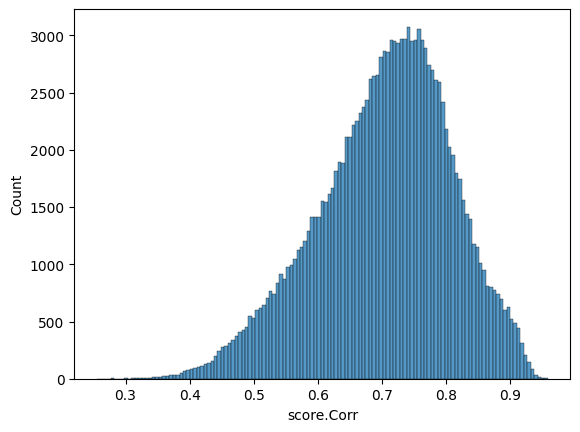

In [70]:
sns.histplot(gb_panel2.eval.ad_map.obs['score.Corr'])

In [71]:
pivot_cols = {
    'cluster': ['Cluster', 'cluster_Corr'],
    'subclass': ['Subclass', 'level3.subclass_Corr'],
    'neighborhood': ['Neighborhood', 'level2.neighborhood_Corr'],
    'class': ['Class', 'level1.class_Corr']
}

norm_conf_matrix = gb_panel2.eval.get_confusion_matrix(pivot_cols)

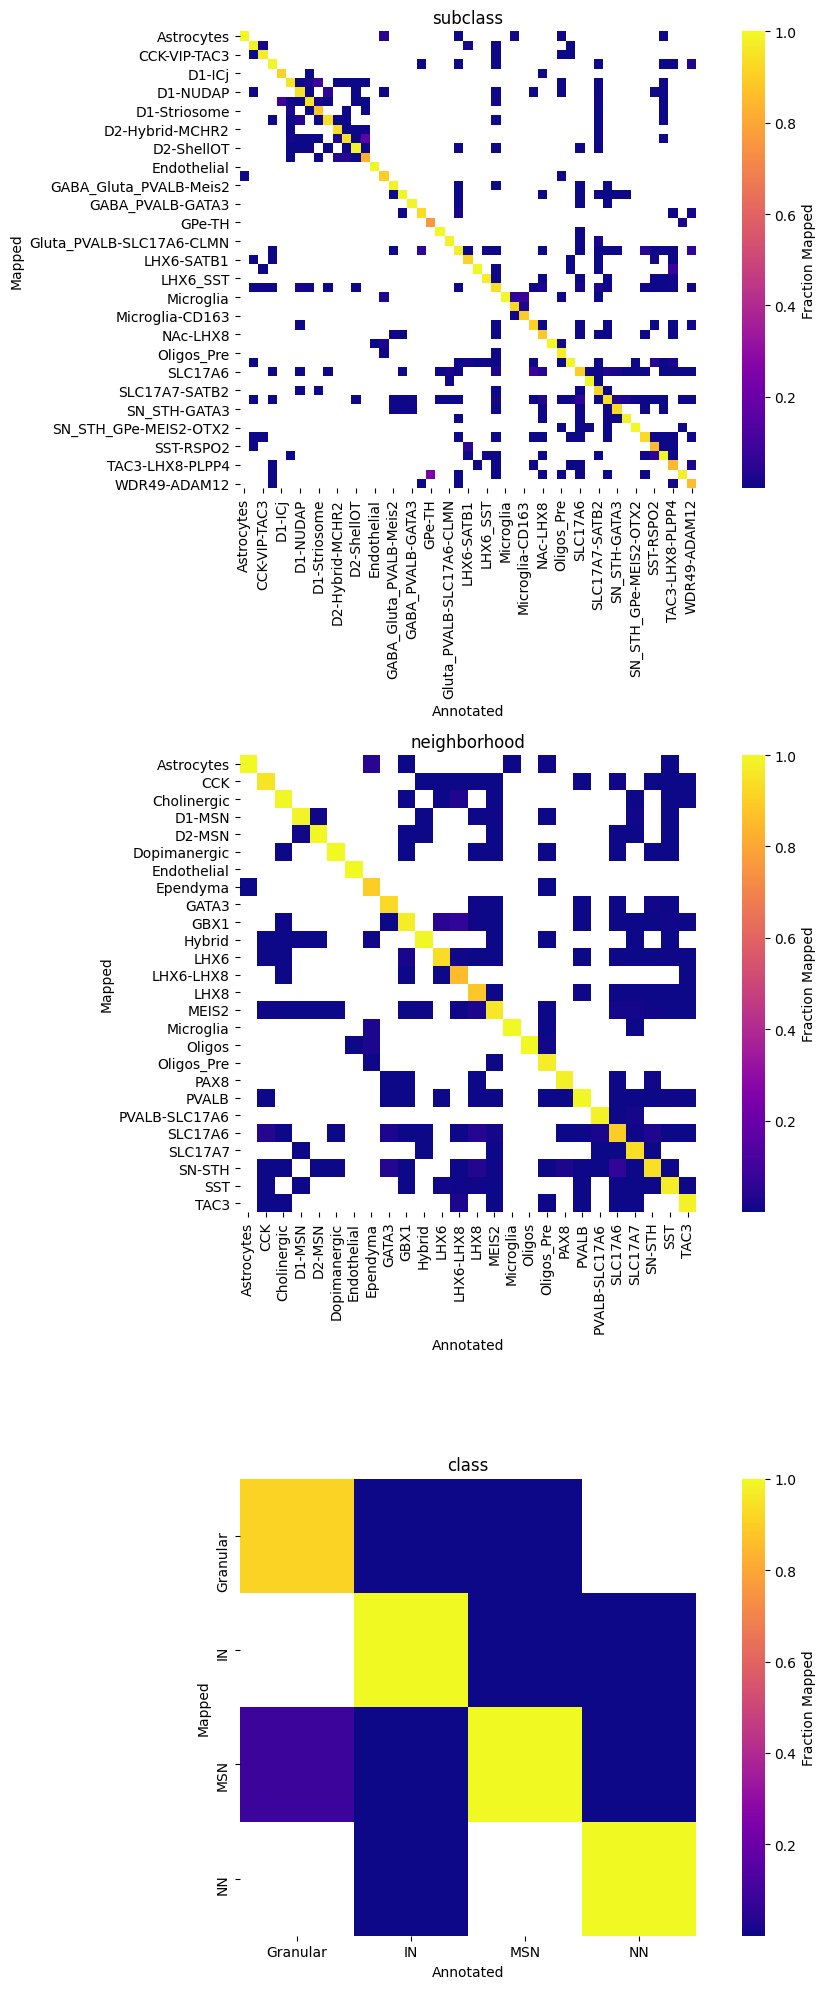

In [72]:
fig, ax = plt.subplots(3, 1, figsize=(10, 20))
                    
for i, level in enumerate(['subclass', 'neighborhood', 'class']):
    matrix = norm_conf_matrix[level].dropna(how='all')
    matrix = matrix.loc[matrix.columns]
    matrix.index.name = 'Mapped'
    sns.heatmap(matrix, cmap='plasma', vmax=1, ax=ax[i], square=True,cbar_kws={'label': 'Fraction Mapped'})
    ax[i].set_title(level)
plt.tight_layout()